In [84]:
import os # currently used for pathing

from bs4 import BeautifulSoup # currently used for parsing SGML format

import pandas as pd

import re # regex, currently used for cleaning

import html # currently used for cleaning

from sklearn.preprocessing import MultiLabelBinarizer # currently used for one-hot encoding

import numpy as np

from skmultilearn.model_selection import iterative_train_test_split # splitting data, using iterative split module for stratified splitting given prevalence of labels with only 2 associated documents

from transformers import BertTokenizer # currently used for tokenizing input

import torch # currently used for converting one-hot encoded topics into PyTorch tensor

from torch.utils.data import Dataset, DataLoader # currently used for feeding data into the model in batches.

from transformers import BertForSequenceClassification # import for the BERT model. This one in particular is the sequence-classification model, which is just BERT with an additional classification layer on top. More suitable for Document Classification.

from transformers import AdamW, get_linear_schedule_with_warmup # Using AdamW as our optimizer, adding learning rate scheduler to adjust learning rate during training

from torch import nn # neural network module from PyTorch. We're retrieving our loss function from the nn module.
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score  # metrics

In [85]:
relative_path = os.path.join('Datasets', 'reuters21578')

In [86]:
sgml_files = [os.path.join(relative_path, f) for f in os.listdir(relative_path) if f.endswith('.sgm')]

In [87]:
# Checking for presence of all .sgm files.

sgml_files

['Datasets\\reuters21578\\reut2-000.sgm',
 'Datasets\\reuters21578\\reut2-001.sgm',
 'Datasets\\reuters21578\\reut2-002.sgm',
 'Datasets\\reuters21578\\reut2-003.sgm',
 'Datasets\\reuters21578\\reut2-004.sgm',
 'Datasets\\reuters21578\\reut2-005.sgm',
 'Datasets\\reuters21578\\reut2-006.sgm',
 'Datasets\\reuters21578\\reut2-007.sgm',
 'Datasets\\reuters21578\\reut2-008.sgm',
 'Datasets\\reuters21578\\reut2-009.sgm',
 'Datasets\\reuters21578\\reut2-010.sgm',
 'Datasets\\reuters21578\\reut2-011.sgm',
 'Datasets\\reuters21578\\reut2-012.sgm',
 'Datasets\\reuters21578\\reut2-013.sgm',
 'Datasets\\reuters21578\\reut2-014.sgm',
 'Datasets\\reuters21578\\reut2-015.sgm',
 'Datasets\\reuters21578\\reut2-016.sgm',
 'Datasets\\reuters21578\\reut2-017.sgm',
 'Datasets\\reuters21578\\reut2-018.sgm',
 'Datasets\\reuters21578\\reut2-019.sgm',
 'Datasets\\reuters21578\\reut2-020.sgm',
 'Datasets\\reuters21578\\reut2-021.sgm']

# Extracting relevant data from Reuters-21578.

The reuters-21578 dataset is structured in SGML format. What will be column headers are differentiated via XML tags. This is evident if you print out the results of 'file.read()'. For our first classification model, we will be using BERT. Given this, we are mainly interested in the 'title' and 'body' tags for tokenization and later input. In addition to tokenizing text and titles, we are also interested in preparing labels. The labels for each document in this dataset are conveniently indicated by the 'topics' tag.

It should be noted that the 'body' tag seems to disappear after we have parsed via BeautifulSoup. To work around this, we have simply replaced the 'body' opening and closing tags with the 'content' tag (which can be parsed via BeautifulSoup).

In [88]:
# Function to extract document text and topics where the 'topics' field of the 'REUTERS' tag is set to 'YES'
def extract_reuters_data(sgml_file):
    with open(sgml_file, 'r', encoding='latin-1') as file: # ? Why latin-1 as our encoding parameter?
        content = file.read()
    content = content.replace('<BODY>', '<CONTENT>').replace('</BODY>', '</CONTENT>')
    soup = BeautifulSoup(content, 'lxml') # ? Why 'lxml'?
    
    documents = []
    for reuters in soup.find_all('reuters'):
        if reuters.get('topics') == 'YES':
            topics = [topic.text for topic in reuters.topics.find_all('d')] if reuters.topics else []
            title = reuters.find('title').text if reuters.find('title') else ''
            body = reuters.find('content').text if reuters.find('content') else ''

            documents.append({'topics': topics, 'title': title, 'body' : body})
    return documents

In [89]:
# Extract all documents from the SGML files in the relative path
all_documents = []
for sgml_file in sgml_files:
    all_documents.extend(extract_reuters_data(sgml_file))

# Convert the list of documents to a dataframe
df = pd.DataFrame(all_documents)

# Display the first few rows of the dataframe
df.head()

,topics,title,body
0,[cocoa],BAHIA COCOA REVIEW,Showers continued throughout the week in\nthe ...
1,"[grain, wheat, corn, barley, oat, sorghum]",NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESERVE,The U.S. Agriculture Department\nreported the ...
2,"[veg-oil, linseed, lin-oil, soy-oil, sun-oil, ...",ARGENTINE 1986/87 GRAIN/OILSEED REGISTRATIONS,Argentine grain board figures show\ncrop regis...
3,[],USX <X> DEBT DOWGRADED BY MOODY'S,Moody's Investors Service Inc said it\nlowered...
4,[earn],CHAMPION PRODUCTS <CH> APPROVES STOCK SPLIT,Champion Products Inc said its\nboard of direc...


# Data Cleaning

In [90]:
# 1. Remove newline characters
df['body'] = df['body'].str.replace('\n', ' ', regex=False)
df['title'] = df['title'].str.replace('\n', ' ', regex=False)

In [91]:
# # 2. (OPTIONAL, TEST WITH AND WITHOUT FOR IMPACT ON PERFORMANCE METRICS) Remove angle brackets and everything inside them from the 'title' and 'body' columns
# df['title'] = df['title'].apply(lambda x: re.sub(r'<.*?>', '', x))
# df['body'] = df['body'].apply(lambda x: re.sub(r'<.*?>', '', x))

In [92]:
# 3. Remove extra spaces
df['body'] = df['body'].apply(lambda x: ' '.join(x.split()))
df['title'] = df['title'].apply(lambda x: ' '.join(x.split()))

In [93]:
# # 4. (OPTIONAL, TEST WITH AND WITHOUT FOR IMPACT ON PERFORMANCE METRICS) Remove special characters except percentage signs and currency symbols.
# df['body'] = df['body'].apply(lambda x: re.sub(r'[^\w\s.,!?%$£]', '', x))
# df['title'] = df['title'].apply(lambda x: re.sub(r'[^\w\s.,!?%$£]', '', x))

In [94]:
# # 5. Optionally, convert to lowercase
# df['body'] = df['body'].str.lower()
# df['title'] = df['title'].str.lower()

In [95]:
# 6. Optionally, filter out short documents
# df = df[df['body'].apply(lambda x: len(x.split()) > 10)]

In [96]:
# 7. Handle HTML/SGML entities
df['body'] = df['body'].apply(html.unescape)
df['title'] = df['title'].apply(html.unescape)

In [97]:
# 8. Combine title and text columns together

df['combined_text'] = df['title'] + " " + df['body']

In [98]:
df

,topics,title,body,combined_text
0,[cocoa],BAHIA COCOA REVIEW,Showers continued throughout the week in the B...,BAHIA COCOA REVIEW Showers continued throughou...
1,"[grain, wheat, corn, barley, oat, sorghum]",NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESERVE,The U.S. Agriculture Department reported the f...,NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESER...
2,"[veg-oil, linseed, lin-oil, soy-oil, sun-oil, ...",ARGENTINE 1986/87 GRAIN/OILSEED REGISTRATIONS,Argentine grain board figures show crop regist...,ARGENTINE 1986/87 GRAIN/OILSEED REGISTRATIONS ...
3,[],USX <X> DEBT DOWGRADED BY MOODY'S,Moody's Investors Service Inc said it lowered ...,USX <X> DEBT DOWGRADED BY MOODY'S Moody's Inve...
4,[earn],CHAMPION PRODUCTS <CH> APPROVES STOCK SPLIT,Champion Products Inc said its board of direct...,CHAMPION PRODUCTS <CH> APPROVES STOCK SPLIT Ch...
...,...,...,...,...
13471,[acq],N.Z.'S CHASE CORP MAKES OFFER FOR ENTREGROWTH,Chase Corp Ltd <CHCA.WE> said it will make an ...,N.Z.'S CHASE CORP MAKES OFFER FOR ENTREGROWTH ...
13472,"[money-fx, dlr, yen]",TOKYO DEALERS SEE DOLLAR POISED TO BREACH 140 YEN,Tokyo's foreign exchange market is watching ne...,TOKYO DEALERS SEE DOLLAR POISED TO BREACH 140 ...
13473,[ship],JAPAN/INDIA CONFERENCE CUTS GULF WAR RISK CHARGES,The Japan/India-Pakistan-Gulf/Japan shipping c...,JAPAN/INDIA CONFERENCE CUTS GULF WAR RISK CHAR...
13474,[ipi],SOVIET INDUSTRIAL GROWTH/TRADE SLOWER IN 1987,The Soviet Union's industrial output is growin...,SOVIET INDUSTRIAL GROWTH/TRADE SLOWER IN 1987 ...


In [99]:
# 9. Check for any rows with missing and/or nan/null titles or bodies, as well as severely diminished title + body combinations. Remove them.

missing_combined_text = df[df['combined_text'].isnull()]
empty_texts = df[df['combined_text'].str.replace(' ', '', regex=False).str.len() <= 26]
print(len(missing_combined_text))
print(empty_texts)

# No null or NaN values detected, as such, we only need to mask those rows with empty values in the combined_text column

df = df[~(df['combined_text'].str.replace(' ', '', regex=False).str.len() <= 26)]

# Notes:

# After combining title and body texts, and removing all spaces, we can see that there are 737 documents without anything in the combined text column. The shortest value in the combined_text column has a length of 27. Anything below a length of 27 is simply blank, as both the condition '<=0' and the condition '<=26' return 737 rows.

0
               topics title body combined_text
68     [money-supply]                         
70     [money-supply]                         
71     [money-supply]                         
72     [money-supply]                         
93     [money-supply]                         
...               ...   ...  ...           ...
12777   [trade, jobs]                         
13136          [earn]                         
13180         [crude]                         
13194           [acq]                         
13267          [earn]                         

[69 rows x 4 columns]


In [100]:
# 10. Remove documents with no labels

empty_topics = df[df['topics'].apply(lambda x: len(x) == 0 if isinstance(x, list) else True)]
print(len(empty_topics.index))
df = df.drop(empty_topics.index)
df.reset_index(drop=True, inplace=True)
df

2110


,topics,title,body,combined_text
0,[cocoa],BAHIA COCOA REVIEW,Showers continued throughout the week in the B...,BAHIA COCOA REVIEW Showers continued throughou...
1,"[grain, wheat, corn, barley, oat, sorghum]",NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESERVE,The U.S. Agriculture Department reported the f...,NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESER...
2,"[veg-oil, linseed, lin-oil, soy-oil, sun-oil, ...",ARGENTINE 1986/87 GRAIN/OILSEED REGISTRATIONS,Argentine grain board figures show crop regist...,ARGENTINE 1986/87 GRAIN/OILSEED REGISTRATIONS ...
3,[earn],CHAMPION PRODUCTS <CH> APPROVES STOCK SPLIT,Champion Products Inc said its board of direct...,CHAMPION PRODUCTS <CH> APPROVES STOCK SPLIT Ch...
4,[acq],COMPUTER TERMINAL SYSTEMS <CPML> COMPLETES SALE,Computer Terminal Systems Inc said it has comp...,COMPUTER TERMINAL SYSTEMS <CPML> COMPLETES SAL...
...,...,...,...,...
11292,[acq],N.Z.'S CHASE CORP MAKES OFFER FOR ENTREGROWTH,Chase Corp Ltd <CHCA.WE> said it will make an ...,N.Z.'S CHASE CORP MAKES OFFER FOR ENTREGROWTH ...
11293,"[money-fx, dlr, yen]",TOKYO DEALERS SEE DOLLAR POISED TO BREACH 140 YEN,Tokyo's foreign exchange market is watching ne...,TOKYO DEALERS SEE DOLLAR POISED TO BREACH 140 ...
11294,[ship],JAPAN/INDIA CONFERENCE CUTS GULF WAR RISK CHARGES,The Japan/India-Pakistan-Gulf/Japan shipping c...,JAPAN/INDIA CONFERENCE CUTS GULF WAR RISK CHAR...
11295,[ipi],SOVIET INDUSTRIAL GROWTH/TRADE SLOWER IN 1987,The Soviet Union's industrial output is growin...,SOVIET INDUSTRIAL GROWTH/TRADE SLOWER IN 1987 ...


In [101]:
# 11. Removing those labels without at least two associated documents in the dataset.

topic_counts = df['topics'].explode().value_counts()
invalid_topics = topic_counts[topic_counts<2].index.tolist()
print(topic_counts)
print(invalid_topics)
df['topics'] = df['topics'].apply(lambda topics_list: [label for label in topics_list if label not in invalid_topics])
df_clean = df[df['topics'].apply(len) > 0].reset_index(drop=True)

topics
earn          3963
acq           2445
money-fx       794
crude          625
grain          621
              ... 
skr              1
rupiah           1
peseta           1
castorseed       1
red-bean         1
Name: count, Length: 119, dtype: int64
['corn-oil', 'rape-meal', 'hk', 'bfr', 'cottonseed', 'lin-meal', 'citruspulp', 'dkr', 'ringgit', 'skr', 'rupiah', 'peseta', 'castorseed', 'red-bean']


In [102]:
# Double checking to make sure none of the single-document topics still remain in any of the lists in the topics column
df_clean['topics'].apply(lambda topics_list: all(label not in invalid_topics for label in topics_list)).value_counts()

topics
True    11297
Name: count, dtype: int64

In [103]:
# Triple Checking
topic_counts = df_clean['topics'].explode().value_counts()
topic_counts

topics
earn             3963
acq              2445
money-fx          794
crude             625
grain             621
                 ... 
rye                 2
lin-oil             2
sun-meal            2
linseed             2
groundnut-oil       2
Name: count, Length: 105, dtype: int64

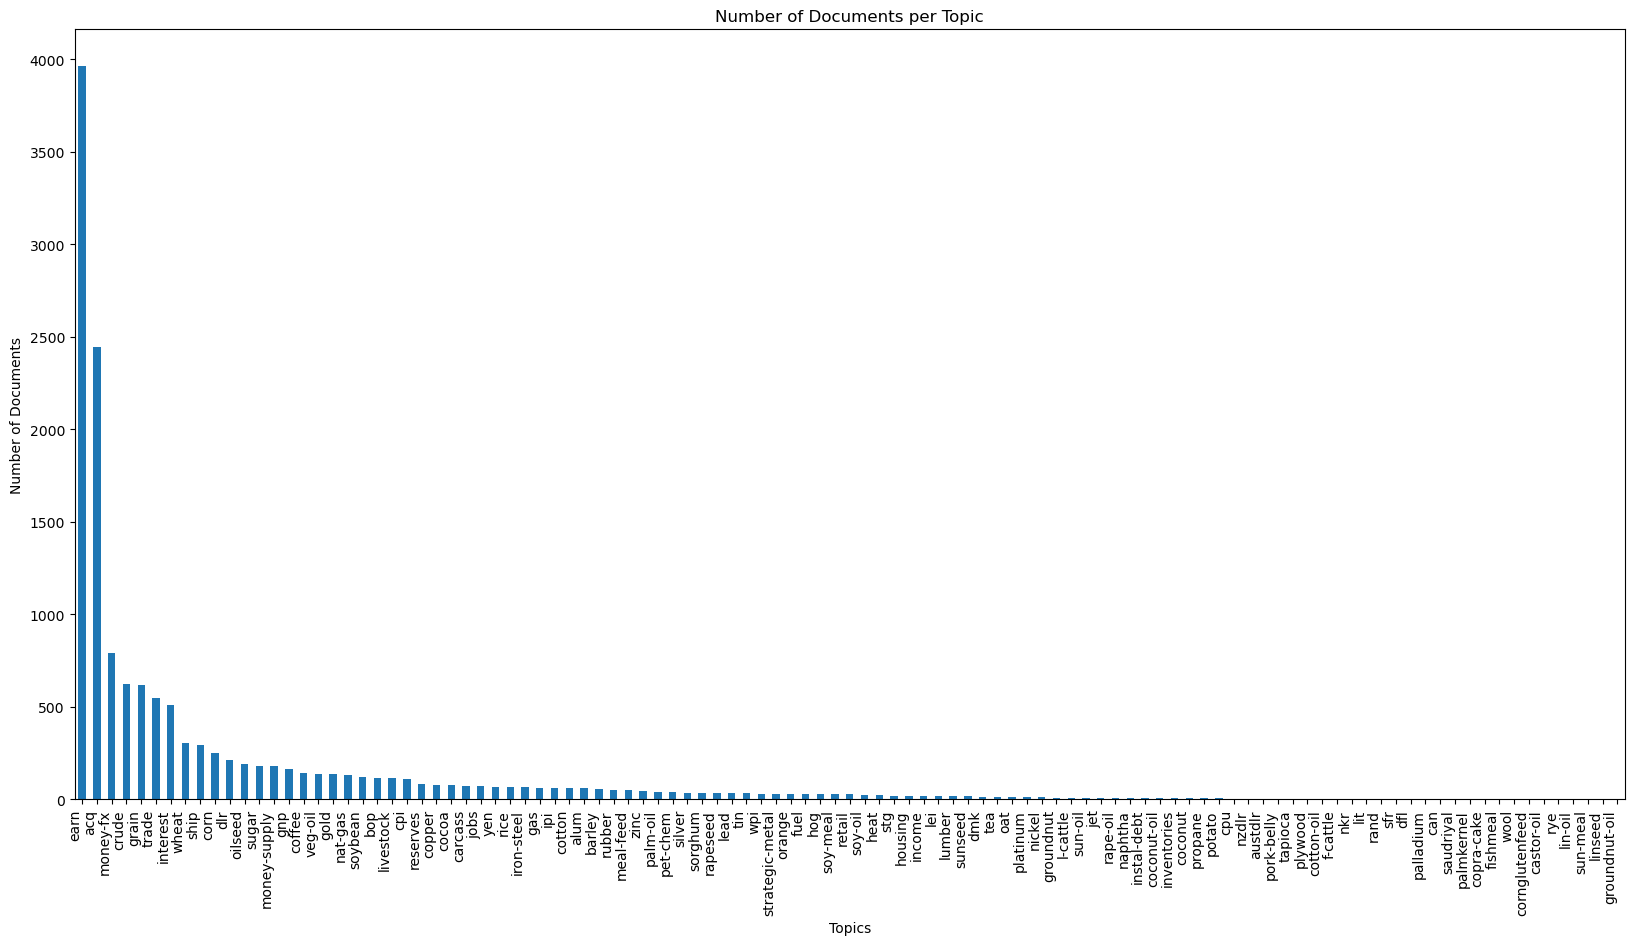

In [104]:
import matplotlib.pyplot as plt

# Bar chart of the number of documents per topic after removing those topics with less than two documents associated
plt.figure(figsize=(20,10))
topic_counts.plot(kind='bar')
plt.title('Number of Documents per Topic')
plt.xlabel('Topics')
plt.ylabel('Number of Documents')
plt.xticks(rotation=90, ha='right')
plt.show()

# One-hot encoding topics column

In [105]:
# Create the MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# One-hot encode the 'topics' column
one_hot_topics = mlb.fit_transform(df_clean['topics'])

# Get the list of all topic names (column names)
topic_names = mlb.classes_

# Convert the one-hot encoded topics back into a dataframe
one_hot_df = pd.DataFrame(one_hot_topics, columns=topic_names)

# Concatenate the one-hot encoded topics with the original dataframe
df_one_hot = pd.concat([df_clean, one_hot_df], axis=1)

# Display the first few rows of the updated dataframe
df_one_hot.head()

,topics,title,body,combined_text,acq,alum,austdlr,barley,bop,can,...,tapioca,tea,tin,trade,veg-oil,wheat,wool,wpi,yen,zinc
0,[cocoa],BAHIA COCOA REVIEW,Showers continued throughout the week in the B...,BAHIA COCOA REVIEW Showers continued throughou...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"[grain, wheat, corn, barley, oat, sorghum]",NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESERVE,The U.S. Agriculture Department reported the f...,NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESER...,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2,"[veg-oil, linseed, lin-oil, soy-oil, sun-oil, ...",ARGENTINE 1986/87 GRAIN/OILSEED REGISTRATIONS,Argentine grain board figures show crop regist...,ARGENTINE 1986/87 GRAIN/OILSEED REGISTRATIONS ...,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
3,[earn],CHAMPION PRODUCTS <CH> APPROVES STOCK SPLIT,Champion Products Inc said its board of direct...,CHAMPION PRODUCTS <CH> APPROVES STOCK SPLIT Ch...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,[acq],COMPUTER TERMINAL SYSTEMS <CPML> COMPLETES SALE,Computer Terminal Systems Inc said it has comp...,COMPUTER TERMINAL SYSTEMS <CPML> COMPLETES SAL...,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Splitting Data

In [106]:
# Extract the combined text and one-hot encoded labels
X = df_one_hot['combined_text'].values  # Combined text (input features)
y = df_one_hot[df_one_hot.columns.difference(['title', 'body', 'topics', 'combined_text'])].values  # One-hot encoded topics (labels)

# Reshape X to 2D as required by iterative_train_test_split
X = np.array(X).reshape(-1, 1) 

# Perform iterative stratified split (80% training, 20% testing)
X_train, y_train, X_test, y_test = iterative_train_test_split(X, y, test_size=0.2)

# Reshape X_train, X_test back to 1D arrays for tokenization
X_train = X_train.ravel()
X_test = X_test.ravel()

# Check the resulting sizes
print(f"Training Set: {len(X_train)} samples")
print(f"Testing Set: {len(X_test)} samples")


Training Set: 9030 samples
Testing Set: 2267 samples


In [107]:
label_names = df_one_hot.columns.difference(['title', 'body', 'topics', 'combined_text'])

In [108]:
label_names

Index(['acq', 'alum', 'austdlr', 'barley', 'bop', 'can', 'carcass',
       'castor-oil', 'cocoa', 'coconut',
       ...
       'tapioca', 'tea', 'tin', 'trade', 'veg-oil', 'wheat', 'wool', 'wpi',
       'yen', 'zinc'],
      dtype='object', length=105)

In [109]:
# Function to check label distribution
def check_label_distribution(y, label_names):
    label_counts = np.sum(y, axis=0)  # Sum the one-hot encoded labels along axis 0
    label_distribution = dict(zip(label_names, label_counts))  # Create a dictionary mapping label names to counts
    return label_distribution

In [110]:
# Checking distribution of labels in our training set
train_label_distribution = check_label_distribution(y_train, label_names)
print("Training Set Label Distribution:")
zero_count_labels_train = []
for label, count in train_label_distribution.items():
    print(f"{label}: {count} occurrences")
    if count == 0:
        zero_count_labels_train.append(label)
print(zero_count_labels_train)
    


Training Set Label Distribution:
acq: 1956 occurrences
alum: 50 occurrences
austdlr: 3 occurrences
barley: 42 occurrences
bop: 93 occurrences
can: 2 occurrences
carcass: 60 occurrences
castor-oil: 1 occurrences
cocoa: 61 occurrences
coconut: 4 occurrences
coconut-oil: 5 occurrences
coffee: 116 occurrences
copper: 62 occurrences
copra-cake: 1 occurrences
corn: 201 occurrences
cornglutenfeed: 1 occurrences
cotton: 50 occurrences
cotton-oil: 3 occurrences
cpi: 90 occurrences
cpu: 3 occurrences
crude: 500 occurrences
dfl: 3 occurrences
dlr: 173 occurrences
dmk: 12 occurrences
earn: 3170 occurrences
f-cattle: 2 occurrences
fishmeal: 2 occurrences
fuel: 22 occurrences
gas: 51 occurrences
gnp: 130 occurrences
gold: 108 occurrences
grain: 497 occurrences
groundnut: 8 occurrences
groundnut-oil: 0 occurrences
heat: 20 occurrences
hog: 22 occurrences
housing: 17 occurrences
income: 14 occurrences
instal-debt: 6 occurrences
interest: 407 occurrences
inventories: 6 occurrences
ipi: 51 occurrences
i

In [111]:
# Check the distribution of labels for our testing set
test_label_distribution = check_label_distribution(y_test, label_names)
print("\nTesting Set Label Distribution:")
zero_count_labels_test = []
for label, count in test_label_distribution.items():
    print(f"{label}: {count} occurrences")
    if count == 0:
        zero_count_labels_test.append(label)
print(zero_count_labels_test)


Testing Set Label Distribution:
acq: 489 occurrences
alum: 12 occurrences
austdlr: 1 occurrences
barley: 12 occurrences
bop: 23 occurrences
can: 1 occurrences
carcass: 15 occurrences
castor-oil: 1 occurrences
cocoa: 15 occurrences
coconut: 2 occurrences
coconut-oil: 2 occurrences
coffee: 29 occurrences
copper: 16 occurrences
copra-cake: 2 occurrences
corn: 50 occurrences
cornglutenfeed: 1 occurrences
cotton: 13 occurrences
cotton-oil: 0 occurrences
cpi: 22 occurrences
cpu: 1 occurrences
crude: 125 occurrences
dfl: 0 occurrences
dlr: 43 occurrences
dmk: 3 occurrences
earn: 793 occurrences
f-cattle: 1 occurrences
fishmeal: 0 occurrences
fuel: 6 occurrences
gas: 13 occurrences
gnp: 33 occurrences
gold: 27 occurrences
grain: 124 occurrences
groundnut: 2 occurrences
groundnut-oil: 2 occurrences
heat: 5 occurrences
hog: 5 occurrences
housing: 4 occurrences
income: 4 occurrences
instal-debt: 1 occurrences
interest: 102 occurrences
inventories: 1 occurrences
ipi: 13 occurrences
iron-steel: 13

## Seems like we have a couple topics that could not be split between the training set and testing set so easily. Going to go ahead and remove them and any documents made topicless by said removal as per method 'b' described in note 2 of the readme.

In [112]:
# Concatenating the zero-count labels from the test and train sets
zero_count_labels_combined = zero_count_labels_test + zero_count_labels_train


# Display how many documents are associated with each of the problematic topics
for topic in zero_count_labels_combined:
    topic_count = df_clean['topics'].apply(lambda topics_list: topic in topics_list).sum()
    print(f"Topic '{topic}' is associated with {topic_count} documents.")

# Only retain those labels/topics that were not zero-count in our previous split
df_clean['topics'] = df_clean['topics'].apply(lambda topics_list: [label for label in topics_list if label not in zero_count_labels_combined])

# Drop any documents that have no remaining topics after filtering
df_clean = df_clean[df_clean['topics'].apply(len) > 0].reset_index(drop=True)

Topic 'cotton-oil' is associated with 3 documents.
Topic 'dfl' is associated with 3 documents.
Topic 'fishmeal' is associated with 2 documents.
Topic 'linseed' is associated with 2 documents.
Topic 'palladium' is associated with 3 documents.
Topic 'sfr' is associated with 3 documents.
Topic 'wool' is associated with 2 documents.
Topic 'groundnut-oil' is associated with 2 documents.
Topic 'sun-meal' is associated with 2 documents.


In [113]:
# One-Hot Encode the topics column again
mlb = MultiLabelBinarizer()
one_hot_topics = mlb.fit_transform(df_clean['topics'])

# Get the list of all valid topic names again
topic_names = mlb.classes_

# Convert the one-hot encoded topics back into a dataframe again
one_hot_df = pd.DataFrame(one_hot_topics, columns=topic_names)

# Concatenate the one-hot encoded topics with the original dataframe again
df_one_hot = pd.concat([df_clean, one_hot_df], axis=1)

In [114]:
# Extract the combined text and one-hot encoded labels for the new split
X = df_one_hot['combined_text'].values  # Combined text (input features)
y = df_one_hot[df_one_hot.columns.difference(['title', 'body', 'topics', 'combined_text'])].values  # One-hot encoded topics (labels)

# Reshaping to fit iterative split requirement
X = np.array(X).reshape(-1, 1)  #

# Perform iterative stratified split
X_train, y_train, X_test, y_test = iterative_train_test_split(X, y, test_size=0.2)

# Reshape X_train, X_test back to 1D arrays for tokenization
X_train = X_train.ravel()
X_test = X_test.ravel()

# Verify the split and check label distributions in the training and testing sets
print(f"Training Set: {len(X_train)} samples")
print(f"Testing Set: {len(X_test)} samples")

# Recheck the label distribution in the new training set
zero_count_labels_train_2 = []
train_label_distribution_2 = check_label_distribution(y_train, topic_names)
print("Training Set Label Distribution after removal:")
for label, count in train_label_distribution_2.items():
    print(f"{label}: {count} occurrences")
    if count == 0:
        zero_count_labels_train_2.append(label)

# Recheck the label distribution in the new testing set
zero_count_labels_test_2 = []
test_label_distribution_2 = check_label_distribution(y_test, topic_names)
print("\nTesting Set Label Distribution after removal:")
for label, count in test_label_distribution_2.items():
    print(f"{label}: {count} occurrences")
    if count == 0:
        zero_count_labels_test_2.append(label)
        
print(zero_count_labels_train_2)
print(zero_count_labels_test_2)

zero_count_labels_combined_2 = zero_count_labels_train_2 + zero_count_labels_test_2

for topic in zero_count_labels_combined_2:
    topic_count = df_clean['topics'].apply(lambda topics_list: topic in topics_list).sum()
    print(f"Topic '{topic}' is associated with {topic_count} documents.")

Training Set: 9030 samples
Testing Set: 2266 samples
Training Set Label Distribution after removal:
acq: 1956 occurrences
alum: 50 occurrences
austdlr: 3 occurrences
barley: 42 occurrences
bop: 93 occurrences
can: 2 occurrences
carcass: 60 occurrences
castor-oil: 1 occurrences
cocoa: 61 occurrences
coconut: 4 occurrences
coconut-oil: 5 occurrences
coffee: 116 occurrences
copper: 62 occurrences
copra-cake: 1 occurrences
corn: 201 occurrences
cornglutenfeed: 1 occurrences
cotton: 50 occurrences
cpi: 90 occurrences
cpu: 3 occurrences
crude: 500 occurrences
dlr: 173 occurrences
dmk: 12 occurrences
earn: 3170 occurrences
f-cattle: 2 occurrences
fuel: 22 occurrences
gas: 51 occurrences
gnp: 130 occurrences
gold: 108 occurrences
grain: 497 occurrences
groundnut: 8 occurrences
heat: 20 occurrences
hog: 22 occurrences
housing: 17 occurrences
income: 14 occurrences
instal-debt: 6 occurrences
interest: 407 occurrences
inventories: 5 occurrences
ipi: 51 occurrences
iron-steel: 54 occurrences
jet: 

## After re-running the notebook until this point several times, it seems that after the second removal, there can still be a couple labels that could not be appropriately split such that both training and testing have at least one instance (not strictly the case, as, on some seeds, the split works out for all remaining labels). I have thus decided, as per the follow up to note 2 in the README, to define a cutoff point for the labels. Labels with document counts below this cutoff will be excluded from the dataset.

## Based on the numbers we're seeing for topics/labels that cannot be easily split in a balanced manner, a cutoff point of 4 or 5 seems appropriate.

In [115]:
topic_counts = df_clean['topics'].explode().value_counts()
invalid_topics = topic_counts[topic_counts<5].index.tolist()
print(topic_counts)
print(invalid_topics)
df_clean['topics'] = df_clean['topics'].apply(lambda topics_list: [label for label in topics_list if label not in invalid_topics])
df_clean = df_clean[df_clean['topics'].apply(len) > 0].reset_index(drop=True)
df_clean['topics'].explode().value_counts()

topics
earn              3963
acq               2445
money-fx           794
crude              625
grain              621
                  ... 
f-cattle             3
cornglutenfeed       2
rye                  2
lin-oil              2
castor-oil           2
Name: count, Length: 96, dtype: int64
['pork-belly', 'nzdlr', 'austdlr', 'cpu', 'tapioca', 'plywood', 'can', 'saudriyal', 'palmkernel', 'copra-cake', 'rand', 'lit', 'nkr', 'f-cattle', 'cornglutenfeed', 'rye', 'lin-oil', 'castor-oil']


topics
earn           3963
acq            2445
money-fx        794
crude           625
grain           621
               ... 
inventories       7
naphtha           7
potato            6
propane           6
coconut           6
Name: count, Length: 78, dtype: int64

In [116]:
df_clean

,topics,title,body,combined_text
0,[cocoa],BAHIA COCOA REVIEW,Showers continued throughout the week in the B...,BAHIA COCOA REVIEW Showers continued throughou...
1,"[grain, wheat, corn, barley, oat, sorghum]",NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESERVE,The U.S. Agriculture Department reported the f...,NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESER...
2,"[veg-oil, soy-oil, sun-oil, soybean, oilseed, ...",ARGENTINE 1986/87 GRAIN/OILSEED REGISTRATIONS,Argentine grain board figures show crop regist...,ARGENTINE 1986/87 GRAIN/OILSEED REGISTRATIONS ...
3,[earn],CHAMPION PRODUCTS <CH> APPROVES STOCK SPLIT,Champion Products Inc said its board of direct...,CHAMPION PRODUCTS <CH> APPROVES STOCK SPLIT Ch...
4,[acq],COMPUTER TERMINAL SYSTEMS <CPML> COMPLETES SALE,Computer Terminal Systems Inc said it has comp...,COMPUTER TERMINAL SYSTEMS <CPML> COMPLETES SAL...
...,...,...,...,...
11285,[acq],N.Z.'S CHASE CORP MAKES OFFER FOR ENTREGROWTH,Chase Corp Ltd <CHCA.WE> said it will make an ...,N.Z.'S CHASE CORP MAKES OFFER FOR ENTREGROWTH ...
11286,"[money-fx, dlr, yen]",TOKYO DEALERS SEE DOLLAR POISED TO BREACH 140 YEN,Tokyo's foreign exchange market is watching ne...,TOKYO DEALERS SEE DOLLAR POISED TO BREACH 140 ...
11287,[ship],JAPAN/INDIA CONFERENCE CUTS GULF WAR RISK CHARGES,The Japan/India-Pakistan-Gulf/Japan shipping c...,JAPAN/INDIA CONFERENCE CUTS GULF WAR RISK CHAR...
11288,[ipi],SOVIET INDUSTRIAL GROWTH/TRADE SLOWER IN 1987,The Soviet Union's industrial output is growin...,SOVIET INDUSTRIAL GROWTH/TRADE SLOWER IN 1987 ...


## Final encode and split.


In [117]:
# One-Hot Encode the topics column again
mlb = MultiLabelBinarizer()
one_hot_topics = mlb.fit_transform(df_clean['topics'])

# Get the list of all valid topic names again
topic_names = mlb.classes_

# Convert the one-hot encoded topics back into a dataframe again
one_hot_df = pd.DataFrame(one_hot_topics, columns=topic_names)

# Concatenate the one-hot encoded topics with the original dataframe again
df_one_hot = pd.concat([df_clean, one_hot_df], axis=1)

In [118]:
# Extract the combined text and one-hot encoded labels for the new split
X = df_one_hot['combined_text'].values  # Combined text (input features)
y = df_one_hot[df_one_hot.columns.difference(['title', 'body', 'topics', 'combined_text'])].values  # One-hot encoded topics (labels)

# Reshaping to fit iterative split requirement
X = np.array(X).reshape(-1, 1)  #

# Perform iterative stratified split
X_train, y_train, X_test, y_test = iterative_train_test_split(X, y, test_size=0.2) # test_size = 0.4 if you want a validation set that includes at least one document for each label/topic present

# Reshape X_train, X_test back to 1D arrays for tokenization
X_train = X_train.ravel()
X_test_temp = X_test.ravel()

# Verify the split and check label distributions in the training and testing sets
print(f"Training Set: {len(X_train)} samples")
print(f"Testing Set: {len(X_test_temp)} samples")

# Recheck the label distribution in the new training set
zero_count_labels_train_2 = []
train_label_distribution_2 = check_label_distribution(y_train, topic_names)
print("Training Set Label Distribution after removal:")
for label, count in train_label_distribution_2.items():
    print(f"{label}: {count} occurrences")
    if count == 0:
        zero_count_labels_train_2.append(label)

# Recheck the label distribution in the new testing set
zero_count_labels_test_2 = []
test_label_distribution_2 = check_label_distribution(y_test, topic_names)
print("\nTesting Set Label Distribution after removal:")
for label, count in test_label_distribution_2.items():
    print(f"{label}: {count} occurrences")
    if count == 0:
        zero_count_labels_test_2.append(label)
        
print(zero_count_labels_train_2)
print(zero_count_labels_test_2)

Training Set: 9025 samples
Testing Set: 2265 samples
Training Set Label Distribution after removal:
acq: 1956 occurrences
alum: 50 occurrences
barley: 42 occurrences
bop: 93 occurrences
carcass: 60 occurrences
cocoa: 61 occurrences
coconut: 4 occurrences
coconut-oil: 5 occurrences
coffee: 116 occurrences
copper: 62 occurrences
corn: 201 occurrences
cotton: 50 occurrences
cpi: 90 occurrences
crude: 500 occurrences
dlr: 173 occurrences
dmk: 12 occurrences
earn: 3170 occurrences
fuel: 22 occurrences
gas: 51 occurrences
gnp: 130 occurrences
gold: 108 occurrences
grain: 497 occurrences
groundnut: 8 occurrences
heat: 20 occurrences
hog: 22 occurrences
housing: 17 occurrences
income: 14 occurrences
instal-debt: 6 occurrences
interest: 407 occurrences
inventories: 5 occurrences
ipi: 51 occurrences
iron-steel: 54 occurrences
jet: 6 occurrences
jobs: 59 occurrences
l-cattle: 7 occurrences
lead: 28 occurrences
lei: 14 occurrences
livestock: 91 occurrences
lumber: 14 occurrences
meal-feed: 41 occu

In [36]:
# Splitting test set into validation and test, ignore if you would rather omit the validation set.

X_val, y_val, X_test, y_test = iterative_train_test_split(X_test, y_test, test_size=0.5)

X_val = X_val.ravel()

In [119]:
X_test = X_test.ravel()

# Check the resulting sizes
print(f"Training Set: {len(X_train)} samples")
print(f"Validation Set: {len(X_val)} samples")
print(f"Testing Set: {len(X_test)} samples")

Training Set: 9025 samples
Validation Set: 2244 samples
Testing Set: 2265 samples


In [38]:
# Check label distribution on the validation set, skip if you have no validation set.

zero_count_labels_val = []
test_label_distribution_3 = check_label_distribution(y_val, topic_names)
print("\nValidation Set Label Distribution after removal:")
for label, count in test_label_distribution_3.items():
    print(f"{label}: {count} occurrences")
    if count == 0:
        zero_count_labels_val.append(label)
        
# Recheck the label distribution in test set after split into validation and test
zero_count_labels_test_3 = []
test_label_distribution_4 = check_label_distribution(y_test, topic_names)
print("\nTesting Set Label Distribution after removal:")
for label, count in test_label_distribution_4.items():
    print(f"{label}: {count} occurrences")
    if count == 0:
        zero_count_labels_test_3.append(label)
        
print(zero_count_labels_val)
print(zero_count_labels_test_3)


Validation Set Label Distribution after removal:
acq: 489 occurrences
alum: 12 occurrences
barley: 10 occurrences
bop: 23 occurrences
carcass: 15 occurrences
cocoa: 15 occurrences
coconut: 2 occurrences
coconut-oil: 1 occurrences
coffee: 29 occurrences
copper: 16 occurrences
corn: 50 occurrences
cotton: 12 occurrences
cpi: 22 occurrences
crude: 125 occurrences
dlr: 43 occurrences
dmk: 3 occurrences
earn: 793 occurrences
fuel: 5 occurrences
gas: 13 occurrences
gnp: 32 occurrences
gold: 27 occurrences
grain: 124 occurrences
groundnut: 1 occurrences
heat: 5 occurrences
hog: 6 occurrences
housing: 4 occurrences
income: 4 occurrences
instal-debt: 1 occurrences
interest: 102 occurrences
inventories: 1 occurrences
ipi: 13 occurrences
iron-steel: 13 occurrences
jet: 1 occurrences
jobs: 15 occurrences
l-cattle: 2 occurrences
lead: 7 occurrences
lei: 3 occurrences
livestock: 23 occurrences
lumber: 4 occurrences
meal-feed: 10 occurrences
money-fx: 159 occurrences
money-supply: 36 occurrences
nap

# Tokenizing text and turning topics into PyTorch tensor

In [120]:
# If you have a validation set, uncomment lines relevant to the validation set.

# Load the pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# Tokenize the text data #
def tokenize_texts(texts, max_length=512):
    return tokenizer(
        texts.tolist(),           # List of text to be tokenized
        padding=True,             # Add padding to make all sequences the same length
        truncation=True,          # Truncate texts that are too long
        max_length=max_length,    # Maximum length of each input sequence
        return_tensors='pt'       # Return PyTorch tensors
    )

# Tokenize the text in the dataframe
X_train_tokenized = tokenize_texts(X_train)
X_test_tokenized = tokenize_texts(X_test)
# X_val_tokenized = tokenize_texts(X_val)

In [121]:
# If you have a validation set, uncomment lines relevant to the validation set.

# Convert labels to PyTorch tensors
train_labels = torch.tensor(y_train.astype(float))
test_labels = torch.tensor(y_test.astype(float))
# val_labels = torch.tensor(y_val.astype(float))

# Custom dataset class extending PyTorch's 'Dataset' class.
class DocumentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Create training and testing datasets
train_dataset = DocumentDataset(X_train_tokenized, train_labels)
test_dataset = DocumentDataset(X_test_tokenized, test_labels)
# val_dataset = DocumentDataset(X_val_tokenized, val_labels)

# Create DataLoader for batching
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16)
# val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Notes: 

# 1. Figure out why we're using a custom dataset class (it seems a bit specific to PyTorch).

# Answer: PyTorch utilizes the 'DataLoader' class to load in datasets. DataLoader expects an extension of the 'Dataset' class to be fed into its instances. We need to extend this Dataset class, therefore, to fit the Dataset class to the format of our input data.

# 2. Figure out the importance of the 'Dataloader' class in PyTorch.

# Answer: Couple of different reasons for the usage of DataLoader in PyTorch:

# a. Creation of data batches. Deep learning models, especially large ones like BERT, are typically trained using mini-batch gradient descent. Instead of feeding one sample at a time (which would be inefficient/slow), data is processed in batches. The DataLoader class batches our data automatically (avoid manually doing so) according to a specified batch_size. Batching matters because training on mutliple samples at once makes better use of computational resources. Mini-batch gradient descent often converges faster and generalizes better than single-sample training (stochastic gradient descent).

# b. DataLoader also provides us with shuffling. Shuffling the dataset at the start of each epoch helps prevent the model from learning dubious/spurious correlations based on order of the data (that is, overfitting to the sequence the data is presented in). 

# c. For larger datasets, loading data can become a bottleneck. DataLoader allows for parallel data loading using multiple cores, meaning that data is prepared in parallel while the GPU (or main CPU) processes the previous batch. You can specify the num_workers argument in DataLoader to determine how many parallel processes (workers) should be used to load data.

# d. Automatic Padding. For text-based models (like BERT), input sequences often have varying lengths. DataLoader handles this by automatically collating and padding variable-length inputs such that they have the same length. DataLoader also lets you define your own custom padding logic when needed.

# Initializing BERT Model and defining Optimizer

In [122]:
# Initialize the BERT model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-cased',
    num_labels=y_train.shape[1],  # Number of labels for multi-label classification, should be fine since our training set encompasses all the different labels that will appear in our dataset.
    problem_type="multi_label_classification"
)

# Move model to GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Notes:
## 1. Numpy Arrays and PyTorch Tensors can have sub-lists, but these sub-lists must have a consistent size - all of them. This is not the case for regular Python lists. Python lists can have sub-lists of varying length/size. When dealing with NumPy arrays or PyTorch tensors, the data is typically stored in a contiguous block of memory, which means each row (or sub-array) needs to have the same number of elements. This requirement allows for efficient matrix operations and memory management.

## 2. multi-label classification vs multi-class classification

## Answer: There are a couple key ways in which the model changes behavior:

## a. The output layer's activation function switches to sigmoid instead of softmax. Softmax produces a probability distribution across all classes that a given document could potentially belong to, and is used in multi-class classification (the situation where each document can only belong to a single type of class, not multiple). That is, it ensures that the sum of the probabilities assigned to each class for a given document sums to 1. On the other hand, a sigmoid activation function works independently on each class, and outputs a probability for each class independently. This allows a document to be predicted as associated with multiple classes instead of just 1.

## b. The loss function is binary cross-entropy instead of cross-entropy loss. In the case of multi-class classification, where only a single class can be assigned to a given document, the loss function assumes there's only one correct class for a given input and penalizes the model based on how far its predicted probability distribution is from the correct one. In our case, that is, multi-label classification, the loss function (BCE) treats whether a given document belongs to a given class as a binary problem. Either an input belongs to a class or not. No two ways about it. This way the model can predict multiple classes as being positive for the same input.

## c. In multi-class classification, the model simply picks the class with the highest probability, given that the probabilities all sum to 1 and only a single class can be assigned for a given input. On the other hand, in multi-label classification, a threshold probability is typically applied. Classes with a probability above this threshold are predicted for a given input.

## 3. Cased vs uncased BERT. Difference is that uncased ignores capitalization. That is, all input text is converted to lowercase prior to tokenization. Cased version preserves case, thus learning to differentiate between cased and uncased versions of the same word based on context/capitalization.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [123]:
# Define the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Set up a learning rate scheduler
epochs = 3
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Notes:

# 1. Why are we using AdamW as our optimizer over regular Adam?

# Answer: AdamW stands for Adam with Weight Decay. It is an extension of the Adam optimizer. Weight decay *prevents overfitting by adding a penalty proportional to the size of the model weights to the loss function. This helps avoid overly large weights which can lead to poor generalization. AdamW is specifically recommended for fine-tuning models like BERT because the original Adam optimizer doesn’t separate weight decay from the gradient update rule, which can lead to worse results. AdamW separates weight decay from the gradient updates, making it more effective for models like BERT.*

# Follow Up: I need to understand how the processes described in the asterisks above fit into the overall learning process for BERT. I'll find some practical examples.

# 2. Significance of learning rate, and why have we chosen 2e-5 as its value.

# Answer: Learning rate controls the size of the step the optimizer takes during each gradient update. Higher rates mean the model's weights are updated more aggressively, lower rates make the updates more cautious. Too high of a rate can cause the model to fail to converge, overshooting optimal solution. Too low can make the model converge too slowly or get stuck in local minima. The value we've chosen here 2e-5 is low enough to ensure fine adjustments whilst still high enough to allow for actual updates.

# Follow up: I need to understand how learning rate fits into the overall training pipeline. Practical examples.

# 3. The learning rate scheduler.

# Answer: A learning rate scheduler is used to adjust the learning rate over the course of training. Decreasing learning rate graduatlly helps the model converge more smoothly. Early in training, a higher learning rate helps explore different parts of the solution space. Later in training, a lower learning rate helps fine-tune around the optimal solution without overshooting. So basically prevention of getting stuck in local minima early on and allowance of finer adjustments in later stages of training. get_linear_schedule_with_warmup is a popular scheduler for BERT. 

# Follow up: Why is get_linear_schedule_with_warmup a popular one? What makes it effective relative to other available ones? When should I be using this as opposed to a different scheduler?

# Answer to follow up: This one just works particularly well for fine tuning pre-trained models like BERT. If our task benefits from a different learning rate decay pattern (like cosine decay), it would make sense to use a different one, but linear schedules with warmup have been shown to work well in a broad range of NLP tasks.

# 4. What are warmup steps, and why have we set them to zero?

# Answer: Warmup steps are basically a 'run up' period during training where the learning rate is gradually increased from 0 to the target (in our case 2e-5). This helps avoid large updates at the beginning of training when model weights may still be unadjusted to new data. In our case, we have set it to zero for now. The learning rate will start at 2e-5 and decrease linearly. We can experiment with warmup steps to see how it impacts performance and model stability.

# Follow up: Is there any logic to how many warmup steps we should have in our case beyond just experimenting and seeing what works?

# Answer to follow up: It's a mix of experimentation and general guidelines. A common heuristic is to use about 10% of the total training steps as warmups.

C:\Users\Manlai\anaconda3\envs\TextClassification\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# TRAINING WITHOUT VALIDATION SET

In [124]:
# Set up loss function for multi-label classification
loss_fn = nn.BCEWithLogitsLoss()

# Training loop
model.train()

for epoch in range(epochs):
    total_loss = 0
    for batch in train_dataloader:
        # Move batch to GPU
        batch = {k: v.to(device) for k, v in batch.items()}

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(**batch)
        loss = loss_fn(outputs.logits, batch['labels'].float())  # Use float() for multi-label

        # Backward pass and optimization step
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss/len(train_dataloader)}")


Epoch 1/3, Loss: 0.14222645549911314
Epoch 2/3, Loss: 0.056072660683926225
Epoch 3/3, Loss: 0.0460276202488262


In [126]:
model.eval()

all_preds = []
all_labels = []
total_test_loss = 0
for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
        loss = loss_fn(outputs.logits, batch['labels'].float())
        total_test_loss += loss.item()
    preds = torch.sigmoid(outputs.logits).cpu().numpy()  # Apply sigmoid to get probabilities
    preds = (preds > 0.5).astype(int)  # Threshold to get binary predictions
    all_preds.append(preds)
    all_labels.append(batch['labels'].cpu().numpy())

all_preds = np.vstack(all_preds)
all_labels = np.vstack(all_labels)

# Calculate metrics
f1 = f1_score(all_labels, all_preds, average='micro')
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='micro')
recall = recall_score(all_labels, all_preds, average='micro')
print(f"Test F1 Score: {f1}")
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")


Test F1 Score: 0.6098807495741057
Test Accuracy: 0.5373068432671082
Test Precision: 0.97890625
Test Recall: 0.44291268999646516


# TRAINING WITH VALIDATION SET

In [44]:
# Set up loss function for multi-label classification
loss_fn = nn.BCEWithLogitsLoss()

# Training loop
model.train()

for epoch in range(epochs):
    total_train_loss = 0
    total_val_loss = 0
    
    # Training phase
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        optimizer.zero_grad()
        outputs = model(**batch)
        loss = loss_fn(outputs.logits, batch['labels'].float())
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_train_loss += loss.item()
    
    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {total_train_loss/len(train_dataloader)}")
    
    # Validation phase
    model.eval()
    all_val_preds = []
    all_val_labels = []
    with torch.no_grad():
        for val_batch in val_dataloader:
            val_batch = {k: v.to(device) for k, v in val_batch.items()}
            outputs = model(**val_batch)
            val_loss = loss_fn(outputs.logits, val_batch['labels'].float())
            total_val_loss += val_loss.item()
            
            # Store validation predictions and labels for metrics calculation
            preds = torch.sigmoid(outputs.logits).cpu().numpy()
            preds = (preds > 0.5).astype(int)
            all_val_preds.append(preds)
            all_val_labels.append(val_batch['labels'].cpu().numpy())
    
    all_val_preds = np.vstack(all_val_preds)
    all_val_labels = np.vstack(all_val_labels)
    
    # Calculate metrics for validation set
    val_f1 = f1_score(all_val_labels, all_val_preds, average='micro')
    print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {total_val_loss/len(val_dataloader)}, Validation F1: {val_f1}")
    
    # Return model to training mode
    model.train()


Epoch 1/3, Training Loss: 0.17613681692410918
Epoch 1/3, Validation Loss: 0.07514872433657342, Validation F1: 0.0
Epoch 2/3, Training Loss: 0.06613430620116346
Epoch 2/3, Validation Loss: 0.05922265628233869, Validation F1: 0.4333333333333334
Epoch 3/3, Training Loss: 0.05654987954918076
Epoch 3/3, Validation Loss: 0.05493041156982699, Validation F1: 0.5699848408287014


In [47]:
# Evaluation loop for the test set
model.eval()

all_test_preds = []
all_test_labels = []

for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
    preds = torch.sigmoid(outputs.logits).cpu().numpy()  # Apply sigmoid to get probabilities
    preds = (preds > 0.5).astype(int)  # Threshold to get binary predictions
    all_test_preds.append(preds)
    all_test_labels.append(batch['labels'].cpu().numpy())

all_test_preds = np.vstack(all_test_preds)
all_test_labels = np.vstack(all_test_labels)

# Calculate the F1 score and accuracy for the test set
test_f1 = f1_score(all_test_labels, all_test_preds, average='micro')
test_accuracy = accuracy_score(all_test_labels, all_test_preds)
test_precision = precision_score(all_test_labels, all_test_preds, average='micro')
test_recall = recall_score(all_test_labels, all_test_preds, average='micro')
print(f"Test F1 Score: {test_f1}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")

Test F1 Score: 0.562768375852488
Test Accuracy: 0.488031914893617
Test Precision: 0.9858407079646018
Test Recall: 0.3937787203958996
